# Social Data Analysis and Visualisation Project

Small Introduction

For each plot: Intro, show the plot, discuss the trends

Discussion: bring everything together

Tuesday 5th May: Draft notebooks

Saturday 9th May: Check in 

Tuesday 12th May: Have a completed version that everyone is okay with. Luca can then do some more to make is amazing but at least at that point we have something we are happy to submit. 

## Initialization

### Import Relevant Packages

In [12]:
# import relevant packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import sklearn as sk
import sklearn.preprocessing as prep
import pydotplus
import math 
import bokeh
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand

from scipy import stats
from folium import plugins
from folium.plugins import HeatMapWithTime, MarkerCluster, HeatMap
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, LinearColorMapper, CDSView, GroupFilter, CustomJS
from bokeh.plotting import figure
from bokeh.transform import transform, factor_cmap
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.palettes import Category20_14, plasma
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

### Initialisation Output Style

In [13]:
# setup bokeh for jupyter notebooks
output_notebook()

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows

# set global plot style
sns.set(style='ticks', palette='muted', color_codes=True)

Loading BokehJS ...

### Load in the Data

In [14]:
cases_data = pd.read_csv("../datasets/cases_by_day.csv", index_col = 0)
deaths_data = pd.read_csv("../datasets/deaths_by_day.csv", index_col = 0)
recovered_data = pd.read_csv("../datasets/recovered_by_day.csv", index_col = 0)

worldbank_data = pd.read_csv("../datasets/worldbank_and_press_freedom.csv",index_col = 1)
worldbank_data = worldbank_data.rename(columns={ worldbank_data.columns[0]: "country" })
# remove duplicated india row ??
worldbank_data = worldbank_data.drop_duplicates(subset=['country'])

# Only keep interesting parts of the responses dataset
responses_data = pd.read_csv("../datasets/corona_policies_cleaned.csv",index_col = 0)
responses_relevant = responses_data.drop(columns= ['ADMIN_LEVEL_NAME','PCODE','LOG_TYPE','NON_COMPLIANCE','SOURCE','SOURCE_TYPE','LINK', 'Alternative source', 'ENTRY_DATE'])
responses_notna = responses_relevant.dropna(subset=['DATE_IMPLEMENTED'])
responses_notna['DATE_IMPLEMENTED'] = pd.to_datetime(responses_notna['DATE_IMPLEMENTED'],format='%Y-%m-%d')

# Data with latitude/longitude for heatmap
lat_lon_confirmed = pd.read_csv("../datasets/lat_lon_confirmed.csv", index_col = 0)
lat_lon_confirmed = lat_lon_confirmed.reset_index()

# Oxford dataset (new format)
oxford_new_data = pd.read_csv("../datasets/oxford_new_cleaned.csv",index_col=0)
oxford_new_data['Date'] = pd.to_datetime(oxford_new_data.Date,format="%Y%m%d")
oxford_new_data = oxford_new_data[oxford_new_data.Date >= '2020-01-22']

/Users/ldorigo/anaconda3/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Heat Map Movie

In [15]:
# column_names = lat_lon_confirmed.columns
# lat_lon = lat_lon_confirmed.iloc[:,:2]
# max_cases = lat_lon_confirmed.iloc[:,2:].sum()
# lat_lon_confirmed.iloc[:,2:] = lat_lon_confirmed.iloc[:,2:]/max_cases
# lat_lon_confirmed.iloc[:,2:] = lat_lon_confirmed.iloc[:,2:]/lat_lon_confirmed.iloc[:,2:].max().max()
# x = lat_lon_confirmed.iloc[:,2:]
# min_max_scaler = prep.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

# lat_lon_normal = pd.concat([lat_lon, df], axis=1)
# lat_lon_normal.columns = column_names
# lat_lon_normal

listoflists = [] 

for col in lat_lon_confirmed.iloc[:,2:].iteritems():
    col = col[1]
    sublist = []
    for index,weight in enumerate(col):
        long = lat_lon_confirmed.Long.iloc[index]
        lat = lat_lon_confirmed.Lat.iloc[index]
        if weight == 0:
            continue
        point = [lat,long,weight]
        sublist.append(point)
    listoflists.append(sublist)

In [16]:
# plot the map
mapmovie = folium.Map(location=[0, 0], zoom_start=1.75, tiles = "Stamen Toner", width = 900, height = 500)

# add the heat map with time
HeatMapWithTime(listoflists).add_to(mapmovie)

# show the movie
mapmovie

## Slider Plot

## Summary Plot

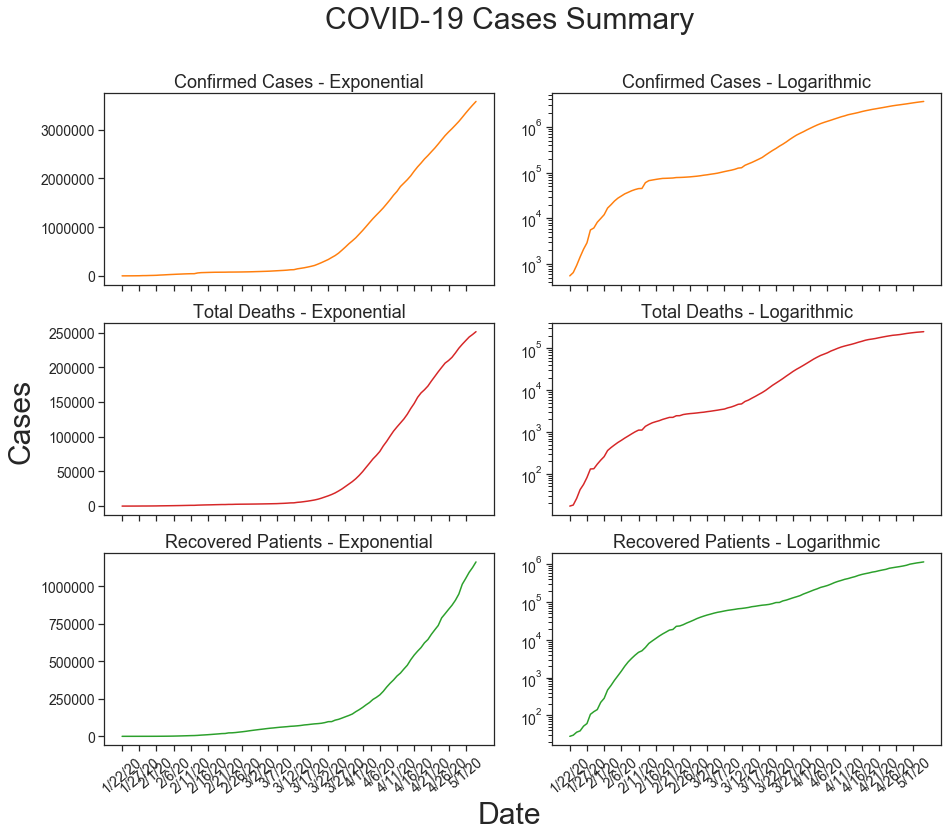

In [17]:
x_ticks = []
i=0
for col in cases_data:
    if(i%5 == 0):
        x_ticks.append(col)
    i = i +1

fig, axs = plt.subplots(3, 2, figsize = (15,12), sharex='col',
                        gridspec_kw={'hspace': 0.2, 'wspace': 0.15})
(ax1, ax2), (ax3, ax4), (ax5, ax6) = axs
fig.suptitle('COVID-19 Cases Summary', fontsize = 30)
ax1.plot(cases_data.columns, cases_data.sum(), 'tab:orange')
ax2.plot(cases_data.columns, cases_data.sum(), 'tab:orange')
ax3.plot(deaths_data.columns, deaths_data.sum(), 'tab:red')
ax4.plot(deaths_data.columns, deaths_data.sum(), 'tab:red')
ax5.plot(recovered_data.columns, recovered_data.sum(), 'tab:green')
ax6.plot(recovered_data.columns, recovered_data.sum(), 'tab:green')

ax1.set(title = "Confirmed Cases - Exponential")
ax2.set(title = "Confirmed Cases - Logarithmic", yscale= "log")
ax3.set(title = "Total Deaths - Exponential")
ax4.set(title = "Total Deaths - Logarithmic", yscale= "log")
ax5.set(title = "Recovered Patients - Exponential")
ax6.set(title = "Recovered Patients - Logarithmic", yscale= "log")

ax1.title.set_size(18)
ax2.title.set_size(18)
ax3.title.set_size(18)
ax4.title.set_size(18)
ax5.title.set_size(18)
ax6.title.set_size(18)

for ax in axs.flat:
    ax.set_xticks(x_ticks)
    ax.tick_params('x', rotation = 40)
    ax.tick_params('y', labelsize ='large')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

fig.text(0.035, 0.5, "Cases", verticalalignment="center", rotation = 90, fontsize = 30);
fig.text(0.5, 0.035, "Date", horizontalalignment="center", rotation = 0, fontsize = 30);

plt.savefig('COVID_Cases_Plot.png')

### Pandemic Curve Plot

In [18]:
# calculate the daily number of active cases
daily_cases_sub_recovered = cases_data.subtract(recovered_data)
daily_cases_data = daily_cases_sub_recovered.subtract(deaths_data)

In [19]:
# initialise focus countries
focus_countries = set(["AUS", "CHN", "DNK", "FRA", "IND", "IRN", "ITA", "MEX", "SWE", "USA"])

# separate the focus countries from the data
data_focused = daily_cases_data.loc[focus_countries]
data_focused = data_focused.T
data_focused

country_code,IRN,ITA,SWE,FRA,MEX,CHN,IND,AUS,DNK,USA
1/22/20,0.0,0.0,0.0,0.0,0.0,502.0,0.0,0.0,0.0,1.0
1/23/20,0.0,0.0,0.0,0.0,0.0,591.0,0.0,0.0,0.0,1.0
1/24/20,0.0,0.0,0.0,2.0,0.0,854.0,0.0,0.0,0.0,2.0
1/25/20,0.0,0.0,0.0,3.0,0.0,1318.0,0.0,0.0,0.0,2.0
1/26/20,0.0,0.0,0.0,3.0,0.0,1957.0,0.0,4.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...
4/30/20,13509.0,101551.0,17501.0,92847.0,5942.0,599.0,24641.0,931.0,2160.0,852481.0
5/1/20,13237.0,100943.0,17862.0,91901.0,6390.0,563.0,26027.0,910.0,2122.0,874503.0
5/2/20,12942.0,100704.0,18408.0,92496.0,7650.0,557.0,27557.0,891.0,2043.0,890788.0
5/3/20,12799.0,100179.0,18633.0,92435.0,7870.0,481.0,29339.0,878.0,2052.0,910206.0


Divide daily cases by population size to allow to truly compare countries:

In [20]:
pops = worldbank_data.loc[focus_countries,'population']
norm_data = data_focused/pops
norm_data

country_code,IRN,ITA,SWE,FRA,MEX,CHN,IND,AUS,DNK,USA
1/22/20,0.000000,0.000000,0.000000,0.000000e+00,0.000000,3.604432e-07,0.000000,0.000000e+00,0.000000,3.056539e-09
1/23/20,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4.243464e-07,0.000000,0.000000e+00,0.000000,3.056539e-09
1/24/20,0.000000,0.000000,0.000000,2.985643e-08,0.000000,6.131842e-07,0.000000,0.000000e+00,0.000000,6.113078e-09
1/25/20,0.000000,0.000000,0.000000,4.478465e-08,0.000000,9.463428e-07,0.000000,0.000000e+00,0.000000,6.113078e-09
1/26/20,0.000000,0.000000,0.000000,4.478465e-08,0.000000,1.405154e-06,0.000000,1.600489e-07,0.000000,1.528269e-08
...,...,...,...,...,...,...,...,...,...,...
4/30/20,0.000165,0.001680,0.001719,1.386040e-03,0.000047,4.300905e-07,0.000018,3.725137e-05,0.000373,2.605641e-03
5/1/20,0.000162,0.001670,0.001754,1.371918e-03,0.000051,4.042420e-07,0.000019,3.641111e-05,0.000366,2.672952e-03
5/2/20,0.000158,0.001666,0.001808,1.380800e-03,0.000061,3.999339e-07,0.000020,3.565088e-05,0.000352,2.722728e-03
5/3/20,0.000156,0.001658,0.001830,1.379890e-03,0.000062,3.453649e-07,0.000022,3.513072e-05,0.000354,2.782080e-03


In [21]:
# convert the Pandas Dataframe to Bokeh ColumnDataSource
source = ColumnDataSource(norm_data)

# intialise a string of x range values, in this case, hours of the day
hours = [str(i) for i in norm_data.index.values]

# create a new figure, specify the x_range, plot_width and title
p = figure(x_range=FactorRange(*hours),plot_width=1000, 
           title = "Pandemic Curve")

# to store vbars
bar = {}

# loop through each of the focus_countries
for i,country in enumerate(focus_countries):
    # create a vbar for each focus_countries
    bar[country] = p.vbar(width=0.5, alpha=0.5, x="index", top=country, 
        source=source, muted_alpha=0.05, muted=True,
        color=Category20_14[i]) 

# add a legend to the plot
legend_items = [(i,[bar[i]]) for i in focus_countries]
legend = Legend(items=legend_items, location=(0,110),click_policy="mute")
p.add_layout(legend,'left')

# add trimmings to the plot and adjust font sizes
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Relative Frequency"
p.title.text_font_size = '24pt'
p.xaxis.axis_label_text_font_size = '14pt'
p.yaxis.axis_label_text_font_size = '14pt'
p.xaxis.major_label_orientation = math.pi/3 

show(p)

In [22]:
cases_data.columns = pd.to_datetime(cases_data.columns)
deaths_data.columns = pd.to_datetime(deaths_data.columns)
recovered_data.columns = pd.to_datetime(recovered_data.columns)

### Interactive Plot 1: Government Measures

In [30]:
# Compute the first day of corona in each country
firstdays = []
firstdays_dict = {}
for row in cases_data.iterrows():
    for index, val in enumerate(row[1]):
#         print(val)
        if val > 0:
            firstdays.append(int(index))
            firstdays_dict[row[0]] = int(index)
            break
            
# Include a column with the (constant) date at which the cases start, and with the number of days beore the country experiences a case.
new_df = pd.DataFrame(index=cases_data.index)
firstday_dates = pd.Series(pd.to_datetime(['22-01-2020'])).repeat(len(new_df))
new_df = new_df.assign(initial_day=firstday_dates.values)
new_df = new_df.assign(days_before_first_case = firstdays)

# Add column with the date of the first case
initial_dates = []
for row in new_df.iterrows():
#     print("row: {}".format(row))
    initial_dates.append(row[1].initial_day + pd.DateOffset(days=row[1].days_before_first_case))
new_df = new_df.assign(first_case_date = initial_dates)
no_nans = new_df.dropna()        


In [31]:
# # Add worldbank data:
# full_data = no_nans.merge(worldbank_data, left_index=True, how='left',right_index=True)

# Merge al this with cases & measures data:
cases_and_measures = no_nans.merge(responses_notna,left_index=True,right_on = 'ISO',how='right' )

In [32]:
# For each measure, compute how many days passed betweeen the first day in that country and the measure
cases_and_measures = cases_and_measures.assign( implementation_after_pandemic = (cases_and_measures.DATE_IMPLEMENTED - cases_and_measures.initial_day).dt.days)
cases_and_measures = cases_and_measures.assign( implementation_after_case_in_country = (cases_and_measures.DATE_IMPLEMENTED - cases_and_measures.first_case_date).dt.days)
cases_and_measures_nona = cases_and_measures.dropna()
# drop measures that happened before the 22 january (since that's when the data starts)
cases_and_measures_nona = cases_and_measures_nona[(cases_and_measures_nona.DATE_IMPLEMENTED > '2020-01-22') & (cases_and_measures_nona.DATE_IMPLEMENTED < '2020-05-01')]


# Compute the number of cases in the country when the measure was implemented
dates = pd.to_datetime(cases_data.T.index)
cases_by_date = cases_data.T.reindex(index = dates)

cases_on_measure = []
for measure in cases_and_measures_nona.iterrows():
    mdate = measure[1].DATE_IMPLEMENTED
    miso = measure[1].ISO
#     print(cases_by_date.loc[mdate,miso])
    cases_on_measure.append(cases_by_date.loc[mdate,miso])
    
cases_and_measures_nona['cases_on_measure'] = cases_on_measure

In [33]:
TOOLTIPS = [
    ("Country", "@COUNTRY"),
    ("Cases on day of implementation", "$y{int}"),
    ("Days passed since first case in country", "$x"),
    ("Policy","@MEASURE - @COMMENTS")
#     ("desc", "@desc"),
]

# We just generate many random colors to represent different countries...
colors = [bokeh.colors.RGB(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)) for i in range(500)]

source_1 = ColumnDataSource(cases_and_measures_nona)
COUNTRIES = list(cases_and_measures_nona.COUNTRY.unique())

measures_plot = figure(width=1100, y_axis_type="log",x_range = (0,70),title='Comparison of the timings of measures in different countries')
markers = [measures_plot.square,measures_plot.cross,measures_plot.circle,measures_plot.x,measures_plot.triangle,measures_plot.diamond,measures_plot.square_cross]

categories = {}
for i, cat in enumerate(cases_and_measures_nona.CATEGORY.unique()):
    view = CDSView(source=source_1, filters=[GroupFilter(column_name='CATEGORY', group=cat)])
    visible = i == 0
    categories[cat] = markers[i](
            source =source_1,
            view=view,
            x= 'implementation_after_case_in_country',
            y='cases_on_measure',
            color =factor_cmap('COUNTRY', colors ,COUNTRIES),
            size=10,
#             marker= MARKERS[i],
            visible = visible
    )
    
# add a legend to the plot
legend_items = [(i,[categories[i]]) for i in categories.keys()]
legend = Legend(items=legend_items, location=(0,110),click_policy="hide")
measures_plot.add_layout(legend,'left')

measures_plot.xaxis.axis_label = "Days since first case in the country"
measures_plot.yaxis.axis_label = "Cases on the day the measure was introduced"
measures_plot.title.text_font_size = '24pt'
measures_plot.xaxis.axis_label_text_font_size = '14pt'
measures_plot.yaxis.axis_label_text_font_size = '14pt'


# Let's try to highlight the points that are of the same country as the hovered one ...

# Add a hover tool, that sets the link data for a hovered circle
# code = """
# const links = %s
# const data = {'x0': [], 'y0': [], 'x1': [], 'y1': []}
# const indices = cb_data.index.indices
# for (var i = 0; i < indices.length; i++) {
#     const start = indices[i]
#     for (var j = 0; j < links[start].length; j++) {
#         const end = links[start][j]
#         data['x0'].push(circle.data.x[start])
#         data['y0'].push(circle.data.y[start])
#         data['x1'].push(circle.data.x[end])
#         data['y1'].push(circle.data.y[end])
#     }
# }
# segment.data = data
# """ 
code = """
for (const property in object) {
  console.log(`${property}: ${object[property]}`);
}

"""
callback = CustomJS(code=code, args= {"categories": categories})

measures_plot.add_tools(HoverTool(tooltips=TOOLTIPS, callback=callback, renderers= list(categories.values())))
show(measures_plot)

### Healthcare Expenditure

In [34]:
# indicator_data = worldbank_data[["gdp_per_capita", "universal_healthcare_coverage_index", "hospital_beds_per_1000", "physicians_per_1000", "health_expenditure_per_capita", "government_effectiveness", "political_stability"]]
plot_data = worldbank_data.loc[:,["gdp_per_capita", "health_expenditure_per_capita","population"]]
plot_data = plot_data.drop('SMR')
country_sum = cases_data.iloc[:,-1]
plot_data = plot_data.assign(cases = country_sum)
plot_data = plot_data.assign(cases_per_capita = plot_data.cases/plot_data.population)
data_complete = plot_data.dropna()

In [35]:
source = ColumnDataSource(data_complete)


TOOLTIPS = [
    ("Country", "@country_code"),
#     ("(x,y)", "($x, $y)"),
#     ("desc", "@desc"),
]

gdp_plot = figure(tooltips=TOOLTIPS,)
health_plot = figure(tooltips=TOOLTIPS)
plots = [gdp_plot,health_plot]
indicators = ['gdp_per_capita','health_expenditure_per_capita']
for plot, indicator in zip(plots,indicators):
    plot.circle(x=indicator,y='cases_per_capita',source=source,size = 5)
    
    X = data_complete[indicator].values.reshape(-1, 1)
    y = data_complete.cases_per_capita
    reg = LinearRegression().fit(X,y)
    y_predicted = reg.predict(data_complete[indicator].values.reshape(-1,1))
    score = reg.score(X,y)
    plot.line(data_complete[indicator],y_predicted,color='red', legend_label="R^2: {}".format(score))
    plot.xaxis.axis_label = indicator
    plot.yaxis.axis_label = "Cases (adjusted by population)"
    plot.title.text_font_size = '24pt'
    plot.xaxis.axis_label_text_font_size = '14pt'
    plot.yaxis.axis_label_text_font_size = '14pt'
    plot.xaxis.major_label_orientation = math.pi/3 
    
    # show(p)
show(row(plots))

# Let's try multiple regression to see if we get a better fit!

X = data_complete[indicators].values
y = data_complete.cases_per_capita.values
regression = LinearRegression().fit(X,y)
print("R-square for multiple regression on both GDP and health expendigure: {}. This is slightly better whan with just the GDP.".format(regression.score(X,y)))

TypeError: 'tuple' object is not callable

## Interactive Plot 2: Healthcare System (bubble chart, animated?)

In [36]:
# Begin by only keeping rows in the worldbank data that have the info we need:

worldbank_data_with_uhc = worldbank_data[worldbank_data.universal_healthcare_coverage_index.notna()]
worldbank_data_with_hospitalbeds = worldbank_data_with_uhc[worldbank_data_with_uhc.hospital_beds_per_1000.notna()]

oxford_with_worldbank = oxford_new_data.merge(worldbank_data,left_on='CountryCode',right_index=True,how='left')

# Simply measuring the "speed of lockdown" doesn't work - it's hard to define a lockdown, and not all countries made one.
# Instead, I calculate the number of days until the stringency index is more than 50.

countrycodes = oxford_with_worldbank.CountryCode.unique()

days_before_high_stringency = {}
for cc in countrycodes:
    country_series = oxford_with_worldbank[oxford_with_worldbank.CountryCode == cc]
    for i, index in enumerate(country_series.StringencyIndex):
        if index > 50:
            days_before_high_stringency[cc] = i
            break
            
days_from_outbreak_to_high_stringency = {}

for cc in countrycodes:
    if (cc not in days_before_high_stringency.keys()) or (cc not in firstdays_dict.keys()):
        print("missing cc: " + cc)
        continue
    else:
        days_from_outbreak_to_high_stringency[cc] = days_before_high_stringency[cc] - firstdays_dict[cc]

missing cc: BDI
missing cc: GUM
missing cc: LSO
missing cc: NIC
missing cc: PRI
missing cc: SWE
missing cc: TWN


In [37]:
from_outbreak_to_high_stringency_df = pd.DataFrame(list(days_from_outbreak_to_high_stringency.values()),index=days_from_outbreak_to_high_stringency.keys())
dataset_for_plot = worldbank_data.merge(from_outbreak_to_high_stringency_df,left_index=True, right_index = True,how="inner").dropna(subset=['universal_healthcare_coverage_index',"hospital_beds_per_1000"]).rename({0:"from_outbreak_to_stringent"},axis="columns")

dataset_small = dataset_for_plot.loc[:,["hospital_beds_per_1000","universal_healthcare_coverage_index","from_outbreak_to_stringent","country"]]



In [38]:
TOOLTIPS = [
    ("Country", "@country"),
#     ("Cases on day of implementation", "$y{int}"),
#     ("Days passed since first case in country", "$x"),
#     ("Policy","@MEASURE - @COMMENTS")
#     ("desc", "@desc"),
]

# We just generate many random colors to represent different countries...
colors = [bokeh.colors.RGB(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)) for i in range(500)]

source_2 = ColumnDataSource(dataset_small)
COUNTRIES = list(dataset_small.country.unique())

speed_of_reaction_plot = figure(width=1100,title='Rapidity of response as a function of the healthcare capacity')
# markers = [measures_plot.square,measures_plot.cross,measures_plot.circle,measures_plot.x,measures_plot.triangle,measures_plot.diamond,measures_plot.square_cross]

# categories = {}
# for i, cat in enumerate(cases_and_measures_nona.CATEGORY.unique()):
#     view = CDSView(source=source_1, filters=[GroupFilter(column_name='CATEGORY', group=cat)])
#     visible = i == 0
#     categories[cat] = markers[i](
#             source =source_1,
#             view=view,
#             x= 'implementation_after_case_in_country',
#             y='cases_on_measure',
#             color =factor_cmap('COUNTRY', colors ,COUNTRIES),
#             size=10,
# #             marker= MARKERS[i],
#             visible = visible
#     )

speed_of_reaction_plot.circle(
    source= source_2,
    x = 'universal_healthcare_coverage_index',
    y= 'from_outbreak_to_stringent',
    size = 'hospital_beds_per_1000',
    color =factor_cmap('country', colors ,COUNTRIES),
)

speed_of_reaction_plot.add_tools(HoverTool(tooltips=TOOLTIPS))

    
# add a legend to the plot
# legend_items = [(i,[categories[i]]) for i in categories.keys()]
# legend = Legend(items=legend_items, location=(0,110),click_policy="hide")
# speed_of_reaction_plot.add_layout(legend,'left')
# 
speed_of_reaction_plot.xaxis.axis_label = "Universal Healthcare Coverage Index"
speed_of_reaction_plot.yaxis.axis_label = "Days between outbreak in country and stringency index >50"
speed_of_reaction_plot.title.text_font_size = '24pt'
speed_of_reaction_plot.xaxis.axis_label_text_font_size = '14pt'
speed_of_reaction_plot.yaxis.axis_label_text_font_size = '14pt'

show(speed_of_reaction_plot)


## Political State (government effectiveness & political stability VS. rate of increase?)

In [39]:
## Let's first see if it's possible to find peaks in the curves.
# Scipy has a handy little function :-)

days_before_peak = {}

for cc in countrycodes:
    try: 
        testseries = daily_cases_data.loc[cc]    
    except KeyError:
        continue
    try:
        tentative_peak = find_peaks(testseries,distance = 1000)[0][0] # distance=1000 to only return the highst peak.)
    except IndexError:
        # If no peaks are found, the curve hasn't reached a peak at all:
        peak = len(testseries)
        has_peaked= False
    # If the curve hasn't reached a peak yet,the function returns a wrong value. 
    # we just check if the latest value is higher than the found peak
    if testseries[-1] > testseries[tentative_peak]:
        # subtract the days until outbreak to get the actual speed in that country:
        peak = len(testseries)
        has_peaked = False
    else:
        peak = tentative_peak
        has_peaked = True
    try:
        firstday = firstdays_dict[cc]
    except KeyError:
        continue
    days_before_peak[cc] = [peak-firstday, has_peaked]
    
peaks_df = pd.DataFrame(days_before_peak.values(), index= days_before_peak.keys())
peaks_df.columns = ['days_before_peak','has_peaked']
peaks_and_wb = peaks_df.merge(worldbank_data, left_index=True,right_index=True, how='inner')

In [126]:
# indicator = 'rule_of_law'
# indicator = 'health_expenditure_per_capita'
# indicator = "gni_per_capita"
# indicator = "transparency_accountability_public_sector"
# indicator = "freedom_score"
# indicator = "voice_and_accountability"
# indicator = "corruption_control"
# indicator = "under_poverty_line_percent"
# indicator = "government_effectiveness"
# indicator = "regulatory_quality"
# indicator = "political_stability"


vrange = np.linspace(peaks_and_wb[indicator].min(),peaks_and_wb[indicator].max(),num=8)
dist = vrange[2]-vrange[1]
middlepoints = [(vrange[i] + vrange[i+1])/2 for i in range(len(vrange)-1)]
averages = []
in_bin = []
amount_in_bin = []
for i in range(len(vrange) -1 ):
    start = vrange[i]
    stop = vrange[i+1]
    countries = peaks_and_wb[(peaks_and_wb[indicator] >= start) & (peaks_and_wb[indicator] < stop)]
    in_bin.append(", ".join(list(countries.country)))
    if len(countries) == 0:
        averages.append(0)
        continue
    count = 0
    for c in countries.iterrows():
        if c[1].has_peaked:
            count += 1
    avg = count/len(countries)
    averages.append(avg)
   
TOOLTIPS = [
    ("Countries in this bin", "@countries_peaked"),
    (indicator, "@midpoints"),
    ("Proportion of countries that have reached a peak", "@proportion_peaked")
#     ("Cases on day of implementation", "$y{int}"),
#     ("Days passed since first case in country", "$x"),
#     ("Policy","@MEASURE - @COMMENTS")
#     ("desc", "@desc"),
]

bin_df = pd.DataFrame()
bin_df['midpoints'] = middlepoints
bin_df['proportion_peaked'] = averages
bin_df['countries_peaked'] = in_bin

source_bin = ColumnDataSource(bin_df)
binary_plot = figure(tooltips=TOOLTIPS,width = 1200 ,title="Proportion of countries that have peaked based on different indicators")

# for mp, av in zip(middlepoints, averages):
binary_plot.vbar(
    source = source_bin,
    x = "midpoints", 
    top = "proportion_peaked",
    width = dist - 0.03 * dist
)

binary_plot.xaxis.axis_label = indicator
binary_plot.yaxis.axis_label = "Proportion of countries that peaked"
binary_plot.title.text_font_size = '24pt'
binary_plot.xaxis.axis_label_text_font_size = '14pt'
binary_plot.yaxis.axis_label_text_font_size = '14pt'


show(binary_plot)

## Stringency Measures Plot (similar to Oxford University Visualisation) (interactive)

## Stringency vs. Number of Coronavirus Cases (include linear regression line)

In [ ]:
# prepare the data

stringency = pd.read_csv("OxCGRT_latest.csv")
stringency_df = pd.DataFrame(stringency, columns = ['CountryName', 'CountryCode', 'Date', 'StringencyIndex']) 

# remove countries that do not have complete data from the 01/01/2020 to the 24/04/2020
stringency_df = stringency_df[~stringency_df.CountryCode.str.contains("CPV")]
stringency_df = stringency_df[~stringency_df.CountryCode.str.contains("LSO")]
stringency_df = stringency_df[~stringency_df.CountryCode.str.contains("MAC")]

stringency_df.drop(stringency_df.tail(1).index,inplace=True) 
stringency_df["StringencyIndex"] = pd.to_numeric(stringency_df["StringencyIndex"])
stringency_df2 = stringency_df
stringency_df2.set_index(['CountryCode', 'Date'] )
stringency_df3 = stringency_df
dates = stringency_df3['Date'].unique()
stringency_df4 = pd.DataFrame(columns = dates)
stringency_df4['CountryCode'] = stringency_df['CountryCode'].unique()
stringency_df5 = stringency_df4.set_index(['CountryCode'])
for i in range(147): #151 countries
    tmp = np.asarray(stringency_df['StringencyIndex'].iloc[i*115:115+115*i])
    stringency_df5.iloc[i,:] =tmp

# remove the final row
stringency_df5 = stringency_df5.iloc[:147]

# remove all data before the 22/01/20 when the cases_data starts
stringency_df5 = stringency_df5.drop(['1/01/2020', '2/01/2020', '3/01/2020', '4/01/2020', '5/01/2020', '6/01/2020', '7/01/2020', 
                     '8/01/2020', '9/01/2020', '10/01/2020', '11/01/2020', '12/01/2020', '13/01/2020', '14/01/2020', 
                     '15/01/2020', '16/01/2020', '17/01/2020', '18/01/2020', '19/01/2020', '20/01/2020', '21/01/2020']
                    , axis=1)

In [ ]:
cases_data = pd.read_csv("cases_by_day.csv", index_col = 0)

In [ ]:
# make sure both datasets use datetime objects
stringency_df5.columns = pd.to_datetime(stringency_df5.columns)
cases_data.columns = pd.to_datetime(cases_data.columns)

In [ ]:
# remove last three columns so both data sets have the same date range
cases_data = cases_data.iloc[:, :-3]

In [ ]:
total_cases = cases_data['2020-04-24']
max_stringency = stringency_df5.max(axis = 1)

In [ ]:
horizontal_stack = pd.concat([total_cases, max_stringency], axis=1)
horizontal_stack.columns = ['Cases', 'Stringency']
horizontal_stack.dropna()

In [ ]:
list_x = horizontal_stack['Cases']
list_y = horizontal_stack['Stringency']
desc = horizontal_stack.index


source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('desc', '@desc'),
])

p = figure(plot_width=600, plot_height=400, tools=[hover], title="Relationship Between Number of Coronavirus Cases and Government Response", x_axis_type="log",)
p.circle('x', 'y', size=10, source=source)

show(p)

## Epidemic curve + stringency measure (bar plot identical to the 'epidemic curve', where the color represents stringency level)

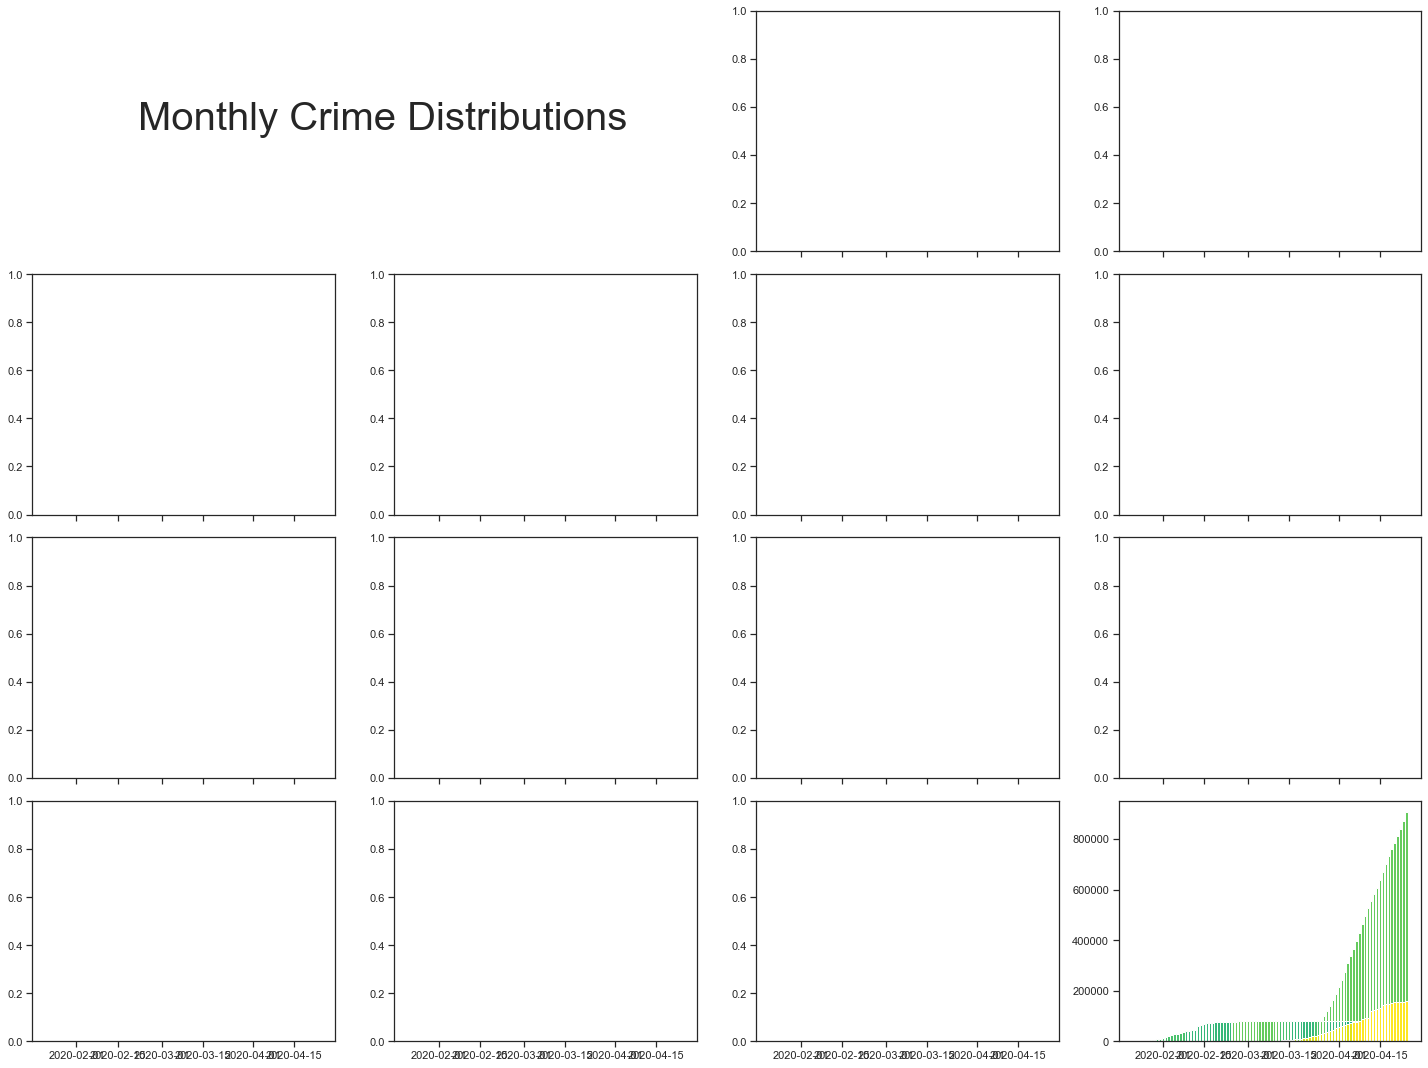

In [230]:
# initialise focus countries
focus_countries = set(["AUS", "CHN", "DNK", "FRA", "IND", "IRN", "ITA", "MEX", "SWE", "USA"])

# separate the focus countries from the data
data_stringency_focused = stringency_df5.loc[focus_countries].T
data_stringency_focused = data_stringency_focused.reset_index()
data_stringency_focused = data_stringency_focused.iloc[:, 1:].astype('float64')
cases_data_focused = cases_data.loc[focus_countries].T
cases_data_focused = cases_data_focused.reset_index()

# initialise the figure
fig, axes = plt.subplots(4, 4, sharex = True)

# adjust the size of the figure so all subplots fit inside
fig.set_figheight(15)
fig.set_figwidth(20)

# set title for the figure
fig.suptitle("Monthly Crime Distributions", ha = "left", x=0.1, y=0.9, fontsize = 40)

# plot each of the different crime type on their own subplot
for index1, country in enumerate(focus_countries):
    
    # get the right subplot
    index1 += 2 
    axis = axes[index1//4,index1%4]
    
    y = data_stringency_focused[country]/100
    colors = cm.viridis(y)
    plt.bar(cases_data_focused['index'], cases_data_focused[country], color = colors)
    # plt.colorbar(colors)
    
# remove the first two empty plots
fig.delaxes(axes[0,0])
fig.delaxes(axes[0,1])
fig.tight_layout()
 
# fig, ax = plt.subplots(1, 1)
 
# # Get a color map
# my_cmap = cm.get_cmap('jet')
 
# normalise the data for the colours
# norm = data_stringency_focused.iloc[:, 1:]/100
# norm = norm.astype('float64').dtypes
# colors = cm.hsv(norm)
# colors = cm.hsv(norm)


# norm = data_stringency_focused.iloc[:, 1:]/100
# ax.bar(cases_data_focused['index'], height = cases_data_focused['AUS'], color=my_cmap(norm))
# plt.show()

# import matplotlib.pyplot as plt
# from matplotlib import cm
# import numpy as np


# data_stringency_focused.dtypes

# y = data_stringency_focused['SWE']/100
# colors = cm.viridis(y)
# plt.bar(cases_data_focused['index'], cases_data_focused['SWE'], color = colors)
# # plt.colorbar(colors)
# plt.show()

# y
# height = data_stringency_focused.index
# plt.bar(cases_data_focused['index'], height = cases_data_focused['AUS'], color=data_stringency_focused['AUS'])
# plt.show()

# data_stringency_focused

In [200]:
# norm = data_stringency_focused.iloc[:, 1:]/float(100)
# norm = norm.astype('float64').dtypes

# colors = cm.hsv(norm)
data_stringency_focused['AUS']

norm = data_stringency_focused.iloc[:, 1:]/100
norm.dtypes

CountryCode
MEX    float64
ITA    float64
USA    float64
DNK    float64
SWE    float64
IRN    float64
CHN    float64
IND    float64
FRA    float64
dtype: object